This notebook compares different LatentVAE and LatentAutoencoder hyperparameter settings and the corresponding training results.

In [2]:
import yaml

from src.models.latent_vae import LatentVAE
from src.models.latent_autoencoder import LatentAutoencoder

In [4]:
# Model configuration
latent_vae_config_path = "../models/latent_vae/configs/sd35m_to_512d.yaml"
latent_autoencoder_config_path = "../models/latent_autoencoder/configs/sd35m_to_512d.yaml"

# Load latent VAE config
with open(latent_vae_config_path, "r") as f:
    latent_vae_config = yaml.safe_load(f)

# Load latent autoencoder config
with open(latent_autoencoder_config_path, "r") as f:
    latent_autoencoder_config = yaml.safe_load(f)

# Other configuration
latent_vae_ckpt_path = "../models/latent_vae/version_9/checkpoints/last.ckpt"
latent_autoencoder_ckpt_path = "../models/latent_autoencoder/version_0/checkpoints/last.ckpt"

# Initialize LatentVAE model
latent_vae = LatentVAE(
    ddconfig=latent_vae_config["ddconfig"],
    lossconfig=latent_vae_config["lossconfig"],
    embed_dim=latent_vae_config["embed_dim"],
    ckpt_path=latent_vae_ckpt_path,
    monitor="val_total_loss",
)
latent_vae.eval()

# Initialize LatentAutoencoder model
latent_autoencoder = LatentAutoencoder(
    ddconfig=latent_autoencoder_config["ddconfig"],
    lossconfig=latent_autoencoder_config["lossconfig"],
    embed_dim=latent_autoencoder_config["embed_dim"],
    ckpt_path=latent_autoencoder_ckpt_path,
    monitor="val_total_loss",
)
latent_autoencoder.eval()

making attention of type 'none' with 128 in_channels
Working with z of shape (1, 8, 8, 8) = 512 dimensions.
making attention of type 'none' with 128 in_channels
Restored from ../models/latent_vae/version_9/checkpoints/last.ckpt
making attention of type 'none' with 128 in_channels
Working with z of shape (1, 8, 8, 8) = 512 dimensions.
making attention of type 'none' with 128 in_channels
Loaded state dict from ../models/latent_autoencoder/version_0/checkpoints/last.ckpt


LatentAutoencoder(
  (encoder): Encoder(
    (conv_in): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): 

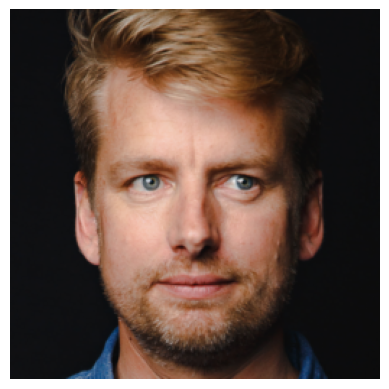

Image shape: torch.Size([1, 3, 256, 256])


In [5]:
# Load one example image
import torch
IMAGE_TENSOR_PATH = "../data/ffhq/pt_images/65432.pt" #54321.pt

img_tensor = torch.load(IMAGE_TENSOR_PATH)

# Add batch dimension: Change from (C, H, W) to (B, C, H, W)
img_tensor = img_tensor.unsqueeze(0)

# Show the image
import matplotlib.pyplot as plt
import numpy as np
img = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
plt.imshow((img + 1) / 2)
plt.axis('off')
plt.show()
print("Image shape:", img_tensor.shape)

In [6]:
# Load Stable Diffusion VAE model
from diffusers import AutoencoderKL

sd_vae = AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-3.5-medium", subfolder="vae")
sd_vae.eval()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [7]:
# Encode the image using the Stable Diffusion VAE
sd_latent = sd_vae.encode(img_tensor).latent_dist.sample()

print("SD Latent shape:", sd_latent.shape)

SD Latent shape: torch.Size([1, 16, 32, 32])


In [10]:
# Encode the latent using the LatentVAE
vae_latent = latent_vae.encode(sd_latent).sample()

# Encode the latent using the LatentAutoencoder
autoencoder_latent = latent_autoencoder.encode(sd_latent)

print("VAE Latent shape:", vae_latent.shape)
print("Autoencoder Latent shape:", autoencoder_latent.shape)

VAE Latent shape: torch.Size([1, 512])
Autoencoder Latent shape: torch.Size([1, 512])


In [14]:
# Decode the latent using the LatentVAE
vae_recon = latent_vae.decode(vae_latent)

# Decode the latent using the LatentAutoencoder
autoencoder_recon = latent_autoencoder.decode(autoencoder_latent)

print("VAE Recon shape:", vae_recon.shape)
print("Autoencoder Recon shape:", autoencoder_recon.shape)

VAE Recon shape: torch.Size([1, 16, 32, 32])
Autoencoder Recon shape: torch.Size([1, 16, 32, 32])


In [15]:
# Decode the latents using the Stable Diffusion VAE
sd_recon_vae = sd_vae.decode(vae_recon).sample
sd_recon_autoencoder = sd_vae.decode(autoencoder_recon).sample

print("SD Recon VAE shape:", sd_recon_vae.shape)
print("SD Recon Autoencoder shape:", sd_recon_autoencoder.shape)

SD Recon VAE shape: torch.Size([1, 3, 256, 256])
SD Recon Autoencoder shape: torch.Size([1, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0067076087..0.95043474].


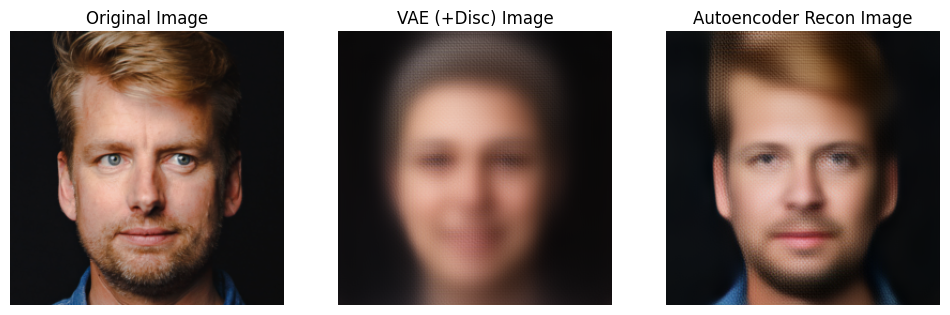

In [17]:
# Show the recon images
recon_img_vae = sd_recon_vae.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
recon_img_autoencoder = sd_recon_autoencoder.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

# Plot the original and recon images
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow((img + 1) / 2)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow((recon_img_vae + 1) / 2)
plt.title("VAE (+Disc) Image")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow((recon_img_autoencoder + 1) / 2)
plt.title("Autoencoder Recon Image")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.014313757..1.0219427].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022205055..0.94719315].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.018711478..1.0025849].


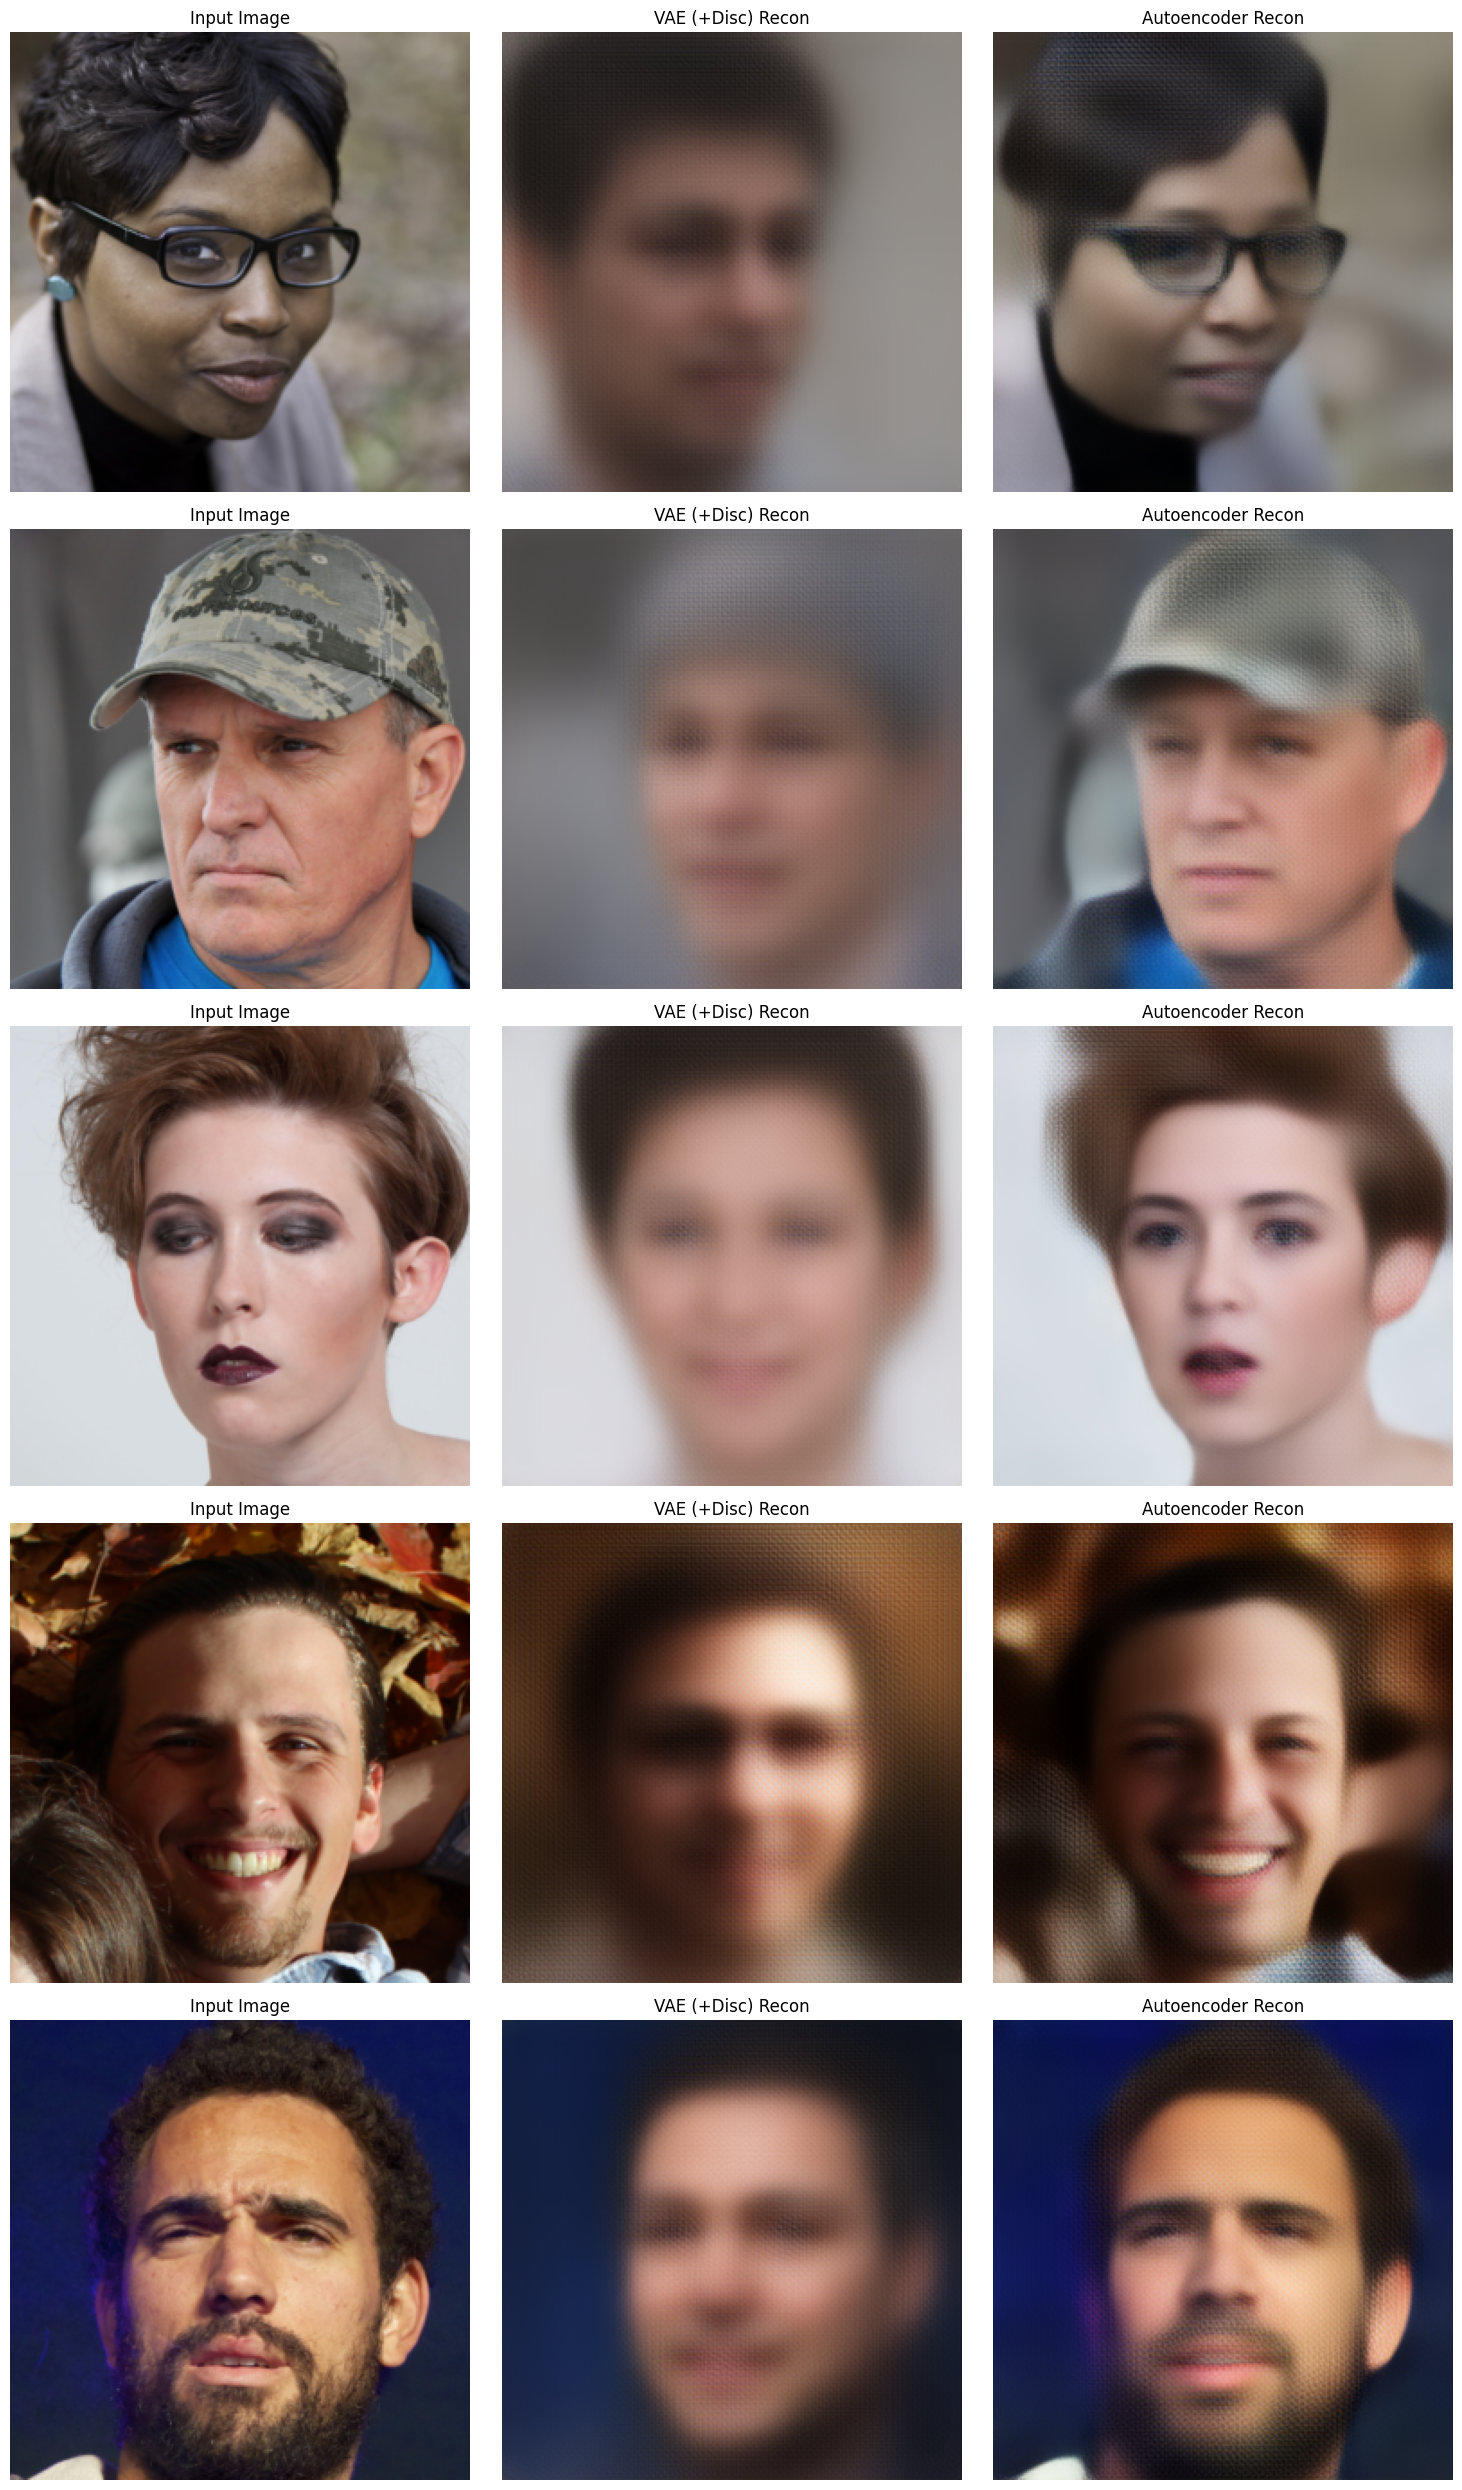

In [20]:
# plot 5 random inputs and recons next to each other
import os
import glob
import random
# Load the images from the folder
IMAGE_FOLDER = "../data/ffhq/pt_images/"
IMAGE_TENSOR_PATHS = glob.glob(os.path.join(IMAGE_FOLDER, "*.pt"))
# Select 5 random images
random.seed(42)
random.shuffle(IMAGE_TENSOR_PATHS)
selected_paths = IMAGE_TENSOR_PATHS[:5]
# Initialize lists to store images and reconstructions
input_images = []
reconstructed_images_vae = []
reconstructed_images_autoencoder = []
# Loop through the selected images
for path in selected_paths:
    # Load the image
    img_tensor = torch.load(path)
    # Add batch dimension: Change from (C, H, W) to (B, C, H, W)
    img_tensor = img_tensor.unsqueeze(0)
    # Encode the image using the Stable Diffusion VAE
    sd_latent = sd_vae.encode(img_tensor).latent_dist.sample()
    # Encode and decode the latent using the LatentVAE
    recon_vae = latent_vae.decode(latent_vae.encode(sd_latent).sample())
    # Encode and decode the latent using the LatentAutoencoder
    recon_autoencoder = latent_autoencoder.decode(latent_autoencoder.encode(sd_latent))
    # Decode the latents using the Stable Diffusion VAE
    sd_recon_vae = sd_vae.decode(recon_vae).sample
    sd_recon_autoencoder = sd_vae.decode(recon_autoencoder).sample
    # Store the images
    input_images.append(img_tensor.squeeze(0).permute(1, 2, 0).numpy())
    reconstructed_images_vae.append(sd_recon_vae.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
    reconstructed_images_autoencoder.append(sd_recon_autoencoder.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
# Plot the input and reconstructed images
fig, ax = plt.subplots(5, 3, figsize=(15, 25))
for i in range(5):
    ax[i, 0].imshow((input_images[i] + 1) / 2)
    ax[i, 0].set_title("Input Image")
    ax[i, 0].axis('off')
    ax[i, 1].imshow((reconstructed_images_vae[i] + 1) / 2)
    ax[i, 1].set_title("VAE (+Disc) Recon")
    ax[i, 1].axis('off')
    ax[i, 2].imshow((reconstructed_images_autoencoder[i] + 1) / 2)
    ax[i, 2].set_title("Autoencoder Recon")
    ax[i, 2].axis('off')
plt.tight_layout()
plt.show()